# Serialising and running Transformations with OpenFE

This notebook will demonstrate:
- how a free energy Network can be planned for performing a relative binding calculation
- how to apply a alchemical Protocol across a fre energy Network
- how to serialise (save) and deserialise (load) Transformations objects
- how to use the command line interface quickrun utility

<div class="alert alert-block alert-warning">
    <b>Warning</b>
    
* The methods in this notebook are still considered pre-release and are designed for testing and feedback.
* Do not use these for production work yet, they are subject to change.
</div>

In [1]:
import gufe
import openfe
from rdkit import Chem
from openff.units import unit

# notebook written for gufe v0.4 and openfe v0.4
print(f"gufe {gufe.__version__}")
print(f"openfe {openfe.__version__}")

gufe v0.4
openfe v0.3.post295+gbd8a2fe


## 1) Planning a free energy Network

First we must load our ligands; the files are read from disk using RDKit, and these RDKit molecules are then wrapped in an openfe `SmallMoleculeComponent` wrapper.  Once molecules are placed into the `SmallMoleculeComponent` wrapper they cannot be modified any further.

In [2]:
def load_ligands(sdf_file) -> list[openfe.setup.SmallMoleculeComponent]:
    # load the ligands from multi molecule SDF file
    # we just need to load using RDKit
    sdf_supp = Chem.SDMolSupplier(sdf_file, removeHs=False)
    # and pass the rdkit Mols into openfe
    return [openfe.setup.SmallMoleculeComponent(m) for m in sdf_supp]

ligands = load_ligands('inputs/ligands.sdf')

For this example we'll construct a simple radial (star) map of the ligands, using the benzene molecule as our reference ligand.

This can be done using the `openfe.setup.ligand_network_planning.generate_radial_network` function.  We will use the `LomapAtomMapper` and forbid elemental changes in our mappings.

In [3]:
# our ligands in the SDF files had titles present,
# these were loaded into RDKit as the "_Name" prop,
# and subsequently populated the `.name` field,
# we can use them to quickly identify the benzene ligand
central = [l for l in ligands if l.name == 'benzene'][0]
outer = [l for l in ligands if l.name != 'benzene']

network = openfe.setup.ligand_network_planning.generate_radial_network(
    ligands=outer,
    central_ligand=central,
    # we can supply one or more Mappers
    mappers=[openfe.setup.LomapAtomMapper(element_change=False)]
)

print(f'We have created "{network}" with {len(network.nodes)} nodes and {len(network.edges)} edges')

We have created "<openfe.setup.network.Network object at 0x7f5fa3865d00>" with 7 nodes and 6 edges


<div class="alert alert-block alert-success">
    <b>Reminder:</b>
    
- The documentation for all functions is available in the notebook via the "?" operator
</div>

In [4]:
?openfe.setup.ligand_network_planning.generate_radial_network

Each node in the network is one of our ligands, while each edge is a `LigandAtomMapping` object

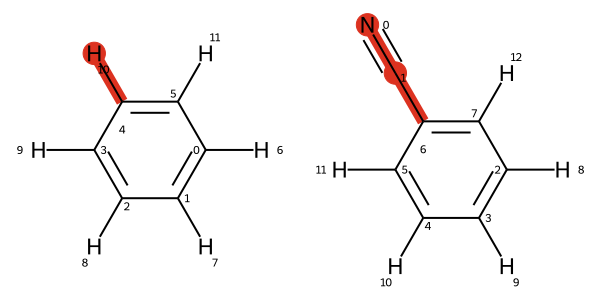

In [5]:
edges = list(network.edges)

edges[0]

## 2) Define a Protocol and apply to a Network

Next we will define a free energy protocol (method) and apply this to all edges in our free energy network
The `openfe.protocols` submodule contains many prepared workflows for estimating ,
here we import an RBFE method which uses the OpenMM MD engine.

<div class="alert alert-block alert-success">
    <b>Note:</b>
    
The `openfe` package will contain a set of workflows,
and other academic groups are currently in the process of writing their own workflows.
Importantly, each of these will present a common interface (API),
allowing them to be used without requiring detailed knowledge.
</div>

In [6]:
from openfe.protocols.openmm_rbfe import RelativeLigandTransform

Firstly each Protocol will provide a sensible set of parameters to start with via the `.default_settings()` method.
These `Settings` objects behave like a Python dictionary, and can be modified to tweak the parameters as required.

In [7]:
settings = RelativeLigandTransform.default_settings()

Each Protocol then takes these settings as their only creation argument.
After this point the settings are fixed, so it is important to inspect and set these ahead of time.

In [8]:
# create the Protocol we'll apply to our network
prot = RelativeLigandTransform(settings)

The Network we planned only featured ligands, so we'll have to load the protein model.
The protein loading is using the `.from_pdb_file` method, which uses a version of the OpenMM protein loading code, modified in preparation of the next generation of OpenFF biopolymer forcefields.
The solvent environment is also defined,
this does not solvate anything at this stage but instead provides an abstract definition of the solvent.

In [9]:
# load our protein model
protein = openfe.setup.ProteinComponent.from_pdb_file('./inputs/181L_mod_capped_protonated.pdb')

# define the solvent state
solvent = openfe.setup.SolventComponent(
    positive_ion='Na', negative_ion='Cl',
    neutralize=True, ion_concentration=0.15 * unit.molar
)

With all the components in our end states defined, we can loop over all edges of the free energy Network and define both legs of the alchemical transformation we wish to perform.  These are defined as a `Transformation` object, which holds the chemistry on either end as a `ChemicalSystem` and the `Protocol` we use to move between them.

In [10]:
transformations = []

for edge in network.edges:
    # grab the two ligands in this edge of the Network
    ligA, ligB = edge.componentA, edge.componentB
    
    # define the complete ChemicalSystem for the A and B states
    # these are identical except for the ligand component,
    # representing the alchemical shift we wish to simulate
    stateA_complex = openfe.setup.ChemicalSystem(
        components={'solvent': solvent,
                    'ligand': ligA,
                    'protein': protein},
    )
    stateB_complex = openfe.setup.ChemicalSystem(
        components={'solvent': solvent,
                    'ligand': ligB,
                    'protein': protein},
    
    )
    # similarly define the solvent leg
    stateA_solvent = openfe.setup.ChemicalSystem(
        components={'solvent': solvent, 'ligand': ligA}
    )
    stateB_solvent = openfe.setup.ChemicalSystem(
        components={'solvent': solvent, 'ligand': ligB}
    )
    
    complex_trans = openfe.setup.Transformation(
        stateA=stateA_complex,
        stateB=stateB_complex,
        mapping={'ligand': edge},
        protocol=prot,
    )
    solvent_trans = openfe.setup.Transformation(
        stateA=stateA_solvent,
        stateB=stateB_solvent,
        mapping={'ligand': edge},
        protocol=prot,
    )
    
    transformations.append(complex_trans)
    transformations.append(solvent_trans)

print(f"From {len(network.edges)} edges we have defined {len(transformations)} Transformations")

From 6 edges we have defined 12 Transformations


## 3) Save, load and execute your Transformation elsewhere

With the chemistry and method defined for many edges, we are now ready to perform the calculations.
Inevitably, we will want to farm out these jobs to different resources.
To do this we will need to store the data on disk,
transmit it elsewhere, then run the stored Transformation.

A simple way to save a `Transformation` to disk is to use the `.dump()` method.


<div class="alert alert-block alert-warning">
    <b>Note</b>
    
* This section is provided as a basic way of trying out the OpenFE tools.  A more comprehensive method for executing many jobs is in the works.
* Storing entire campaigns of work this way is inefficient, a more comprehensive and robust method for archiving data is being developed.
</div>

In [11]:
# pick an arbitrary Transformation to demonstrate with
trans = transformations[0]

trans.dump('out.json')

We can see that this has created a file in our local directory.
For users of Gromacs, this json is similar to a compiled `.tpr` file, storing a prepared simulation which is ready to be executed.
If necessary, this file can be copied across to the compute resource to perform the simulation.

<div class="alert alert-block alert-success">
<b>Note:</b>
    
This json file is a complete description of the chemical models, protocol and settings we previously defined.
    It is therefore a source of provenance for the computational work we will perform.
</div>

In [12]:
!ls -ltrh out.json

-rw-rw-r-- 1 richard richard 839K Nov  1 11:20 out.json



This file can be loaded again using the `.load()` method of a `Transformation`.  This will create an identical object:

In [13]:
t2 = openfe.setup.Transformation.load('out.json')

trans == t2

True

To execute the saved transformation,
a convenience utility is provided as part of the openfe command line interface tool called "`quickrun`".

To run a saved json transformation would be:
*  `openfe quickrun out.json`

<div class="alert alert-block alert-success">
<b>Reminder:</b>
    
Cells in a Jupyter notebook starting with `!` are executed using the shell terminal, not Python.
</div>

In [14]:
!openfe quickrun --help

Usage: openfe quickrun [OPTIONS] TRANSFORMATION

  Run the transformation (edge) in the given JSON file in serial.

  To save a transformation as JSON, create the transformation and then save it
  with transformation.dump(filename).

Options:
  -d DIRECTORY  directory to store files in (defaults to temporary directory)
  -o FILE       output file (JSON format) for the final results
  -h, --help    Show this message and exit.
